# Implementing UNET for biomedical image segmentation 
## Pt. 2 - less epochs
In this set of notebooks, I implement UNET for segmentation of biomedical images. Specifically, the kvasir-seg dataset which is comprised of colonoscopy images of polyps with matching masks made by doctors. This is important in identifying GI diseases, such as colorectal cancer, in their early stages.

I will be using pytorch for this set of notebooks (and my fancy new rtx 3060, since I've been having issues with being dropped from colab)

This notebook specifically will be exploring UNET with only 10 epochs instead of 50, with the purpose of seeing what results look like earlier in the model and gaining insight into changes during the training process.

dataset: https://datasets.simula.no/kvasir-seg/

In [1]:

import torch
import torch.nn as nn
import torchvision
import os
import numpy as np
from PIL import Image
from PIL import ImageDraw 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# check that a gpu is being used and its vram
dev = torch.cuda.current_device()
t = torch.cuda.get_device_properties(dev).total_memory
name = torch.cuda.get_device_name(dev)
availability = torch.cuda.is_available()
print(name, ":", round(t/ 1000000000,2), "GB VRAM")
print("cuda availability:", availability)

NVIDIA GeForce RTX 3060 : 12.88 GB VRAM
cuda availability: True


In [3]:
# allow tf32 operations for quicker maths
torch.backends.cudnn.allow_tf32 = True

First, we need to make our datasets. I manually split the dataset in half into separate folders, since I was having issues with splitting it automatically/randomly. The file names of the images and their corresponding masks are the same, which makes this process easier.

In [4]:
root = 'D:\\tensorflow_datasets\\Kvasir-SEG'
testroot='D:\\tensorflow_datasets\\Kvasir-SEG\\test'
def make_dataset(root: str) -> list:
    """Reads a directory with data.
    Returns a dataset as a list of tuples of paired image paths: (img_path, mask_path)
    """
    dataset = []

    # Our dir names
    img_dir = 'images'
    mask_dir = 'masks'   
    
    # Get all the filenames from img folder
    img_fnames = sorted(os.listdir(os.path.join(root, img_dir)))
    
    # Compare file names from mask folder to file names from img:
    for mask_fname in sorted(os.listdir(os.path.join(root, mask_dir))):

            if mask_fname in img_fnames:
                # if we have a match - create pair of full path to the corresponding images
                img_path = os.path.join(root, img_dir, mask_fname)
                mask_path = os.path.join(root, mask_dir, mask_fname)

                item = (img_path, mask_path)
                # append to the list dataset
                dataset.append(item)
            else:
                continue

    return dataset

Now we can make our train and test/validation sets

In [5]:
dataset = make_dataset(root)
print('Our dataset:')
print(*dataset, sep='\n')

Our dataset:
('D:\\tensorflow_datasets\\Kvasir-SEG\\images\\cju0qkwl35piu0993l0dewei2.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\masks\\cju0qkwl35piu0993l0dewei2.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\images\\cju0qoxqj9q6s0835b43399p4.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\masks\\cju0qoxqj9q6s0835b43399p4.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\images\\cju0qx73cjw570799j4n5cjze.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\masks\\cju0qx73cjw570799j4n5cjze.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\images\\cju0roawvklrq0799vmjorwfv.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\masks\\cju0roawvklrq0799vmjorwfv.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\images\\cju0rx1idathl0835detmsp84.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\masks\\cju0rx1idathl0835detmsp84.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\images\\cju0s2a9ekvms080138tjjpxr.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\masks\\cju0s2a9ekvms080138tjjpxr.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\images\\cju0

In [6]:
test_dataset = make_dataset(testroot)
print('Our training dataset:')
print(*test_dataset, sep='\n')

Our training dataset:
('D:\\tensorflow_datasets\\Kvasir-SEG\\test\\images\\cju13cgqmnhwn0988yrainhcp.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\test\\masks\\cju13cgqmnhwn0988yrainhcp.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\test\\images\\cju13fwthn9mq0835gacxgy01.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\test\\masks\\cju13fwthn9mq0835gacxgy01.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\test\\images\\cju13hp5rnbjx0835bf0jowgx.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\test\\masks\\cju13hp5rnbjx0835bf0jowgx.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\test\\images\\cju14g8o4xui30878gkgbrvqj.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\test\\masks\\cju14g8o4xui30878gkgbrvqj.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\test\\images\\cju14hjh2ob2o0835ouz3r5aa.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\test\\masks\\cju14hjh2ob2o0835ouz3r5aa.jpg')
('D:\\tensorflow_datasets\\Kvasir-SEG\\test\\images\\cju14pxbaoksp0835qzorx6g6.jpg', 'D:\\tensorflow_datasets\\Kvasir-SEG\\test\\masks\\cj

To use the datasets properly, we will create a custom torchvision dataset. 

In [7]:
from torchvision.datasets.folder import default_loader
from torchvision.datasets.vision import VisionDataset


class CustomVisionDataset(VisionDataset):
    
    def __init__(self,
                 root,
                 loader=default_loader,
                 img_transform=None,
                 mask_transform=None):
        super().__init__(root,
                         transform=img_transform,
                         target_transform=mask_transform)

        # Prepare dataset
        samples = make_dataset(self.root)

        self.loader = loader
        self.samples = samples
        # list of img images
        self.img_samples = [s[1] for s in samples]
        # list of mask images
        self.mask_samples = [s[1] for s in samples]

    def __getitem__(self, index):
        """Returns a data sample from our dataset.
        """
        # getting our paths to images
        img_path, mask_path = self.samples[index]
        
        # import each image using loader (by default it's PIL)
        img_sample = self.loader(img_path)
        mask_sample = self.loader(mask_path)
        
        # here goes tranforms if needed
        # maybe we need different tranforms for each type of image
        if self.transform is not None:
            img_sample = self.transform(img_sample)
        if self.target_transform is not None:
            mask_sample = self.target_transform(mask_sample)      
        
        # now we return the right imported pair of images (tensors)
        return img_sample, mask_sample

    def __len__(self):
        return len(self.samples)



Now we can make our dataloaders. I use a batch size of 8 here, and might need to reduce that to 4 or lower the image resolution, since I'm pushing the memory limits of my GPU. 

We will need to do a few transforms: convert the images to tensors, make them grayscale, and make sure they are all the same resolution (which is also halved. 

We will also show an example from the first batch of the images and masks.

batch 1:
torch.Size([8, 1, 256, 320])
torch.Size([8, 1, 256, 320])


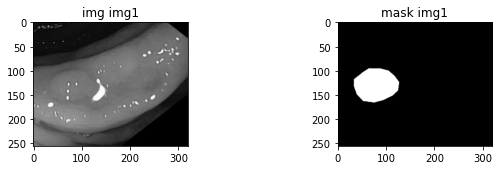

torch.Size([8, 1, 256, 320])
torch.Size([8, 1, 256, 320])


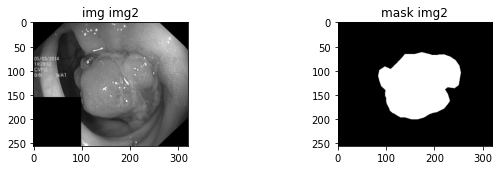

torch.Size([8, 1, 256, 320])
torch.Size([8, 1, 256, 320])


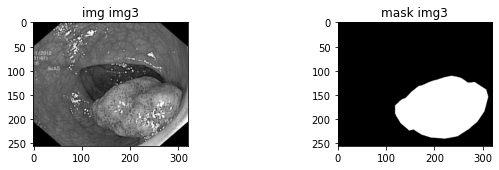

torch.Size([8, 1, 256, 320])
torch.Size([8, 1, 256, 320])


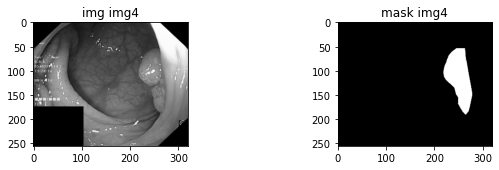

torch.Size([8, 1, 256, 320])
torch.Size([8, 1, 256, 320])


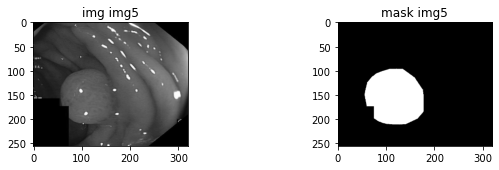

torch.Size([8, 1, 256, 320])
torch.Size([8, 1, 256, 320])


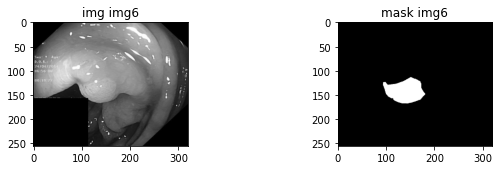

torch.Size([8, 1, 256, 320])
torch.Size([8, 1, 256, 320])


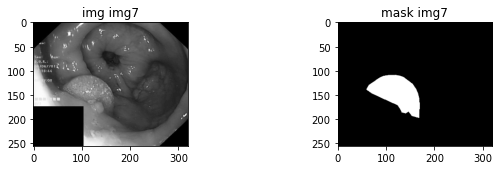

torch.Size([8, 1, 256, 320])
torch.Size([8, 1, 256, 320])


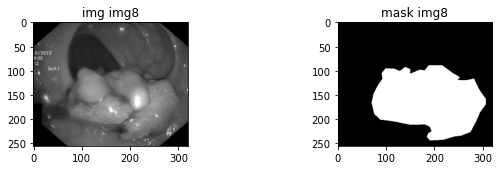

In [8]:
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
from torchvision.transforms import Grayscale

import matplotlib.pyplot as plt


bs=8  # batch size
# convert PIL images to Tensor, make them all the same size, and make them grayscale
transforms = torchvision.transforms.Compose([ToTensor(),Resize((256, 320)),Grayscale(num_output_channels=1)])  
shuffle = True

dataset = CustomVisionDataset(root, img_transform=transforms, mask_transform=transforms)
dataloader = DataLoader(dataset, batch_size=bs, shuffle=shuffle)

test_dataset = CustomVisionDataset(testroot, img_transform=transforms, mask_transform=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=shuffle)

for i, (img, mask) in enumerate(dataloader):
    print(f'batch {i+1}:')
    # some plots
    for i in range(bs):
        plt.figure(figsize=(10, 5))
        plt.subplot(221)
        print(img.size())
        plt.imshow(img[i].squeeze(),cmap='gray')
        plt.title(f'img img{i+1}')
        plt.subplot(222)
        print(mask.size())
        plt.imshow(mask[i].squeeze(),cmap='gray')
        plt.title(f'mask img{i+1}')
        plt.show()
    if i >= 0:
        break
        


Now we can set up our model. 

Model set up with help from the following: 

https://pytorch.org/docs/stable/generated/torch.nn.Module.html

https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html

First, we will set up our contraction path (downsampling).

In [9]:
class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x

Then, since this is a UNET model, we also need to make our expansion path (upscaling/up convolution)

In [10]:
class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

Now we will put it all together into class:

In [11]:
class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1):
        super(UNet, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(in_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv1x1 = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)
        d5 = torch.cat((e4, d5), dim=1)

        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv1x1(d2)

        return out

Now we can make our model. Then we will do a test run to see our input and output sizes and catch any errors before the full training loop

In [12]:
model = UNet()

if torch.cuda.is_available():
    model.cuda()

In [13]:
from torch.autograd import Variable

for i,(img,mask) in enumerate(dataloader):
    input_var = Variable(img.cuda())

    output = model(input_var).cuda()
    print("input size", input_var.size(),
          "output_size", output.size())
    if i>3:
        break

input size torch.Size([8, 1, 256, 320]) output_size torch.Size([8, 1, 256, 320])
input size torch.Size([8, 1, 256, 320]) output_size torch.Size([8, 1, 256, 320])
input size torch.Size([8, 1, 256, 320]) output_size torch.Size([8, 1, 256, 320])
input size torch.Size([8, 1, 256, 320]) output_size torch.Size([8, 1, 256, 320])
input size torch.Size([8, 1, 256, 320]) output_size torch.Size([8, 1, 256, 320])


We will now go on to training our model. We will look at BCE loss with logits and optimize using adam with a lr of 1e-4 and weight decay of 0.1. We can keep track of loss while running, and then compare to our validation loss. 

In [14]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay =0.1)
model.train()

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    losses=[]
    for i, (img, mask) in enumerate(dataloader): 
        img, mask = Variable(img.cuda()), Variable(mask.cuda())

        optimizer.zero_grad()

        outputs = model(img).cuda()
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()

    print("BCE Loss:" , loss)
    losses.append([loss,epoch])
print('Finished Training')


BCE Loss: tensor(0.3987, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3678, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3853, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3241, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3530, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.4704, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3547, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3756, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3496, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3078, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Finished Training


In [19]:
train_losses=[0.3987,
0.3678,
0.3853,
0.3241,
0.3530,
0.4704,
0.3547,
0.3756,
0.3496,
0.3078]

Save the state dicts for future use

In [15]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

torch.save(model.state_dict(), '/statedict')
torch.save(optimizer.state_dict(), '/optstatedict')


Model's state_dict:
Conv1.conv.0.weight 	 torch.Size([64, 1, 3, 3])
Conv1.conv.0.bias 	 torch.Size([64])
Conv1.conv.1.weight 	 torch.Size([64])
Conv1.conv.1.bias 	 torch.Size([64])
Conv1.conv.1.running_mean 	 torch.Size([64])
Conv1.conv.1.running_var 	 torch.Size([64])
Conv1.conv.1.num_batches_tracked 	 torch.Size([])
Conv1.conv.3.weight 	 torch.Size([64, 64, 3, 3])
Conv1.conv.3.bias 	 torch.Size([64])
Conv1.conv.4.weight 	 torch.Size([64])
Conv1.conv.4.bias 	 torch.Size([64])
Conv1.conv.4.running_mean 	 torch.Size([64])
Conv1.conv.4.running_var 	 torch.Size([64])
Conv1.conv.4.num_batches_tracked 	 torch.Size([])
Conv2.conv.0.weight 	 torch.Size([128, 64, 3, 3])
Conv2.conv.0.bias 	 torch.Size([128])
Conv2.conv.1.weight 	 torch.Size([128])
Conv2.conv.1.bias 	 torch.Size([128])
Conv2.conv.1.running_mean 	 torch.Size([128])
Conv2.conv.1.running_var 	 torch.Size([128])
Conv2.conv.1.num_batches_tracked 	 torch.Size([])
Conv2.conv.3.weight 	 torch.Size([128, 128, 3, 3])
Conv2.conv.3.bias 	 t

In [16]:
model.eval()


for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    test_losses=[]
    for i, (img, mask) in enumerate(test_dataloader): 
        img, mask = Variable(img.cuda()), Variable(mask.cuda())
        with torch.no_grad():
            out_data = model(img).cuda()
            
    loss = criterion(outputs, mask)
    test_losses.append([loss,epoch])
    print("BCE Loss:" , loss)

print('Finished Training')

BCE Loss: tensor(0.4879, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.4314, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.4158, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.4848, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.4173, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.5271, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.5084, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3518, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.3350, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
BCE Loss: tensor(0.4018, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Finished Training


In [20]:
test_losses=[0.4879,
0.4314,
0.4158,
0.4848,
0.4173,
0.5271,
0.5084,
0.3518,
0.3350,
0.4018]

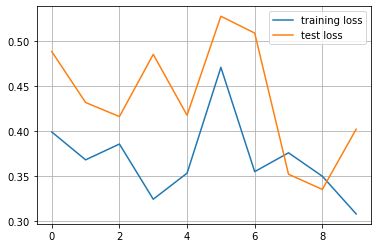

In [21]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.grid(True)
plt.legend(['training loss', 'test loss'])

As we can see, the training loss does tend to be a bit lower than the test loss. This at least gives us a bit better resolution of what's going on in the beginning. In the 50 epoch model, the lowest losses were 0.25 and 0.27 for the train and test sets, respectively. We can see that our lowest losses here aren't actually any better, depite what the 50 epoch model may have indicated (in part due to the shuffling, and in part due to the inherent randomness/variability in the training loop). 

Now, let's look at a sample of our image, mask, and prediction.

batch 1:


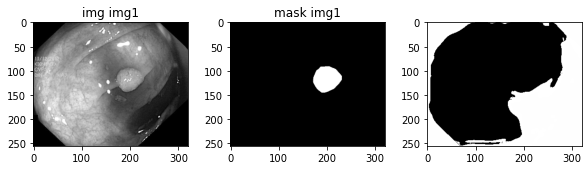

In [26]:

for i, (img, mask) in enumerate(dataloader):
    print(f'batch {i+1}:')
    # some plots
    for i in range(1):
        plt.figure(figsize=(10, 5))
        plt.subplot(231)
        plt.imshow(img[i].squeeze(),cmap='gray')
        plt.title(f'img img{i+1}')
        plt.subplot(232)
        plt.imshow(mask[i].squeeze(),cmap='gray')
        plt.title(f'mask img{i+1}')
        
        pred_img = model(img.cuda()).cuda()
        pred_img = np.squeeze(pred_img.cpu().detach().permute(2, 3, 1,0))
        pred_img1 = pred_img[:, :, 0]
        pred_img2=pred_img1.numpy().astype(np.uint8)
        plt.subplot(233)
        plt.imshow(pred_img2,cmap='gray')
    if i >= 0:
        break

Unlike the 50 epoch model, we can see that the 10 epoch version isn't doing a very good job. This is, of course, as expected - 10 epochs isn't enough for a robust model of complex biomedical images. Though, these results might make good rorschach tests ;-)